# Data Cleaning

In [3]:
rm(list = ls())
library(MASS)
library(ggplot2);library(gridExtra);library(carData);library(car);

In [4]:
install.packages('jtools')
library(jtools)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


### Raw data is examined to detect strange records. 

    BODYFAT         DENSITY           AGE            WEIGHT     
 Min.   : 0.00   Min.   :0.995   Min.   :22.00   Min.   :118.5  
 1st Qu.:12.80   1st Qu.:1.041   1st Qu.:35.75   1st Qu.:159.0  
 Median :19.00   Median :1.055   Median :43.00   Median :176.5  
 Mean   :18.94   Mean   :1.056   Mean   :44.88   Mean   :178.9  
 3rd Qu.:24.60   3rd Qu.:1.070   3rd Qu.:54.00   3rd Qu.:197.0  
 Max.   :45.10   Max.   :1.109   Max.   :81.00   Max.   :363.1  
     HEIGHT        ADIPOSITY          NECK           CHEST       
 Min.   :29.50   Min.   :18.10   Min.   :31.10   Min.   : 79.30  
 1st Qu.:68.25   1st Qu.:23.10   1st Qu.:36.40   1st Qu.: 94.35  
 Median :70.00   Median :25.05   Median :38.00   Median : 99.65  
 Mean   :70.15   Mean   :25.44   Mean   :37.99   Mean   :100.82  
 3rd Qu.:72.25   3rd Qu.:27.32   3rd Qu.:39.42   3rd Qu.:105.38  
 Max.   :77.75   Max.   :48.90   Max.   :51.20   Max.   :136.20  
    ABDOMEN            HIP            THIGH            KNEE      
 Min.   : 69.40  

[1] 39

[1] 42

[1] 182

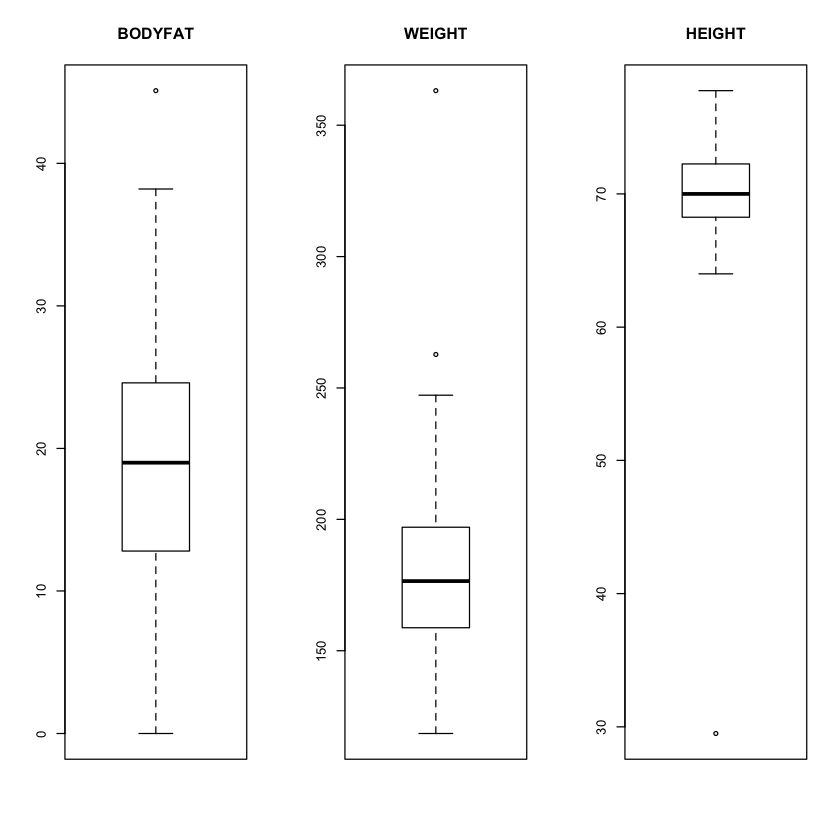

In [5]:
dat = read.csv("BodyFat.csv", row.names = 1)
summary(dat)
par(mfrow=c(1,3))
boxplot(dat$BODYFAT,main="BODYFAT")
boxplot(dat$WEIGHT,main="WEIGHT")
boxplot(dat$HEIGHT,main="HEIGHT")
which(dat$WEIGHT==max(dat$WEIGHT))#39
which(dat$HEIGHT==min(dat$HEIGHT))#42
which(dat$BODYFAT==0)#182

By looking at the dataset summary and boxplots, we detect three outliers: #39 weights extremely heavy, #42 is too short, #182 has zero bodyfat. Then we tried to use the variable values that seem to be true to predict the corresponding outlier variable for these three persons.

### Check for Consistence of BMI versus HEIGHT and WEIGHT

To figure out whether the three outliers were wrong values or just extreme values, we check consistence of BMI versus HEIGHT and WEIGHT, which is bmi=weight/(height)^2*703

In [6]:
dat[39,]; dat[42,]; dat[182,]
weight39=48.9/703*72.25^2 #same as the record, keep 39
height42=sqrt(703*205/29.9) #different from the record, replace it by the new height
dat182=495/1.1089-450 #negative value, delete 182
bodyfat$HEIGHT[42]=height42
bodyfat=bodyfat[-182,]

,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
39,33.8,1.0202,46,363.15,72.25,48.9,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45,29,21.4


,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
42,31.7,1.025,44,205,29.5,29.9,36.6,106,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4


,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
182,0,1.1089,40,118.5,68,18.1,33.8,79.3,69.4,85,47.2,33.5,20.2,27.7,24.6,16.5


ERROR: Error in bodyfat$HEIGHT[42] = height42: object 'bodyfat' not found


##### We delete #182 variable, change the height of #42 and keep the weight of #39.

### Check for Consistency of BODYFAT versus DENSITY

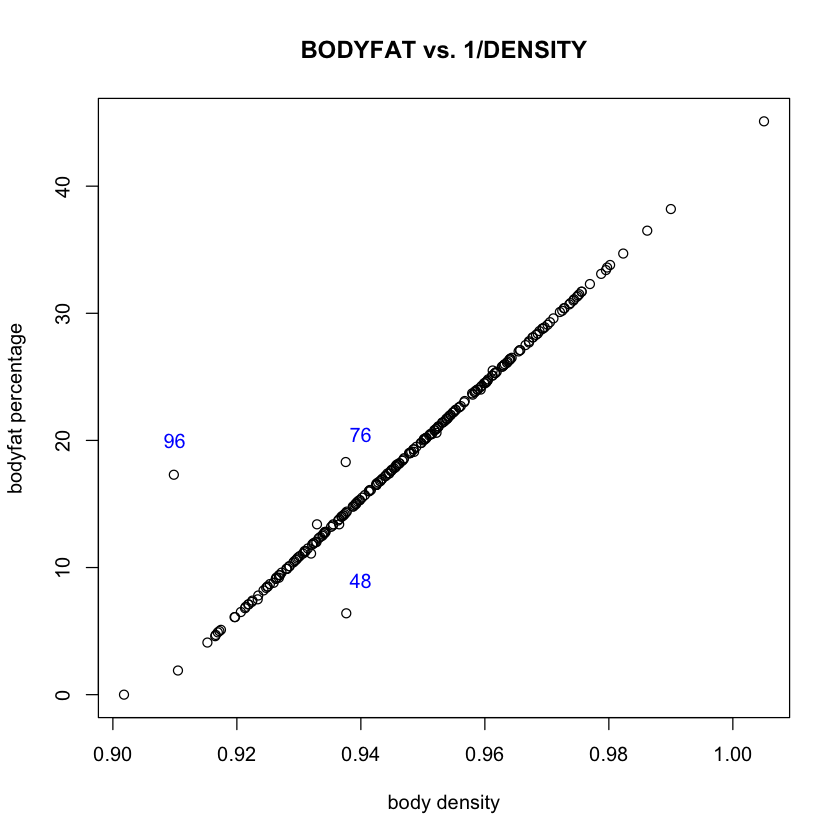

In [7]:
par(mfrow=c(1,1))
plot(y=dat$BODYFAT, x = 1/dat$DENSITY, ylab="bodyfat percentage", xlab="body density", 
     main="BODYFAT vs. 1/DENSITY")
text(0.91,20,"96",col = "blue")
text(0.94,9,"48",col = "blue")
text(0.94,20.5,"76",col = "blue")

Notice there are three data points whose bodyfat is in conflict with density use the siri's formula. 
Since we are not sure of the bodyfat and density which one is wrong.
We search for a bodyfat calculator from https://www.active.com/fitness/calculators/bodyfat as reference to re-calculate these three bodyfat usig Weight and Waist Circumference(Abdomen) two variables.

In [8]:
dat[48,]; dat[96,]; dat[76,]
bodyfat48=495/1.0665-450 #bodyfay wrong
bodyfat96=495/1.0991-450 #density wrong
bodyfat76=495/1.0666-450 #density wrong

,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
48,6.4,1.0665,39,148.5,71.25,20.6,34.6,89.8,79.5,92.7,52.7,37.5,21.9,28.8,26.8,17.9


,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
96,17.3,1.0991,53,224.5,77.75,26.1,41.1,113.2,99.2,107.5,61.7,42.3,23.2,32.9,30.8,20.4


,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
76,18.3,1.0666,61,148.25,67.5,22.9,36,91.6,81.8,94.8,54.5,37,21.4,29.3,27,18.3


after check the bodyfat calculated by siri's formula and by calculator, we got the conclusion that only point48 has wrong bodyfay and we use siri's formula imputed it.

In [9]:
dat$BODYFAT[48]=bodyfat48

### Unify unit

Since the unit of most of the variables is centimeter, to unify units, we change the unit of height to be centimeter. And to make it easier to calculate bmi(ABDOMEN), also change the unit of weight to be kilogram.

In [10]:
dat$WEIGHT=round(dat$WEIGHT*0.45359237,2)
dat$HEIGHT=round(dat$HEIGHT*2.54,2)
dat=dat[,-2] #delete density

# Variable Selection

In [11]:
m_full<-lm(BODYFAT~.,data=dat) #full model
base=base <- lm(BODYFAT~1,data=dat)
AIC.base <- step(base,direction="forward",scope=list(lower=~1,upper=m_full),trace=T)

Start:  AIC=1030.84
BODYFAT ~ 1

            Df Sum of Sq     RSS     AIC
+ ABDOMEN    1    9866.3  5078.3  760.83
+ ADIPOSITY  1    7876.2  7068.4  844.16
+ CHEST      1    7339.9  7604.7  862.59
+ HIP        1    5828.2  9116.4  908.28
+ WEIGHT     1    5593.6  9351.0  914.68
+ THIGH      1    4664.9 10279.7  938.54
+ KNEE       1    3860.6 11084.0  957.53
+ BICEPS     1    3597.7 11346.9  963.43
+ NECK       1    3560.7 11383.9  964.25
+ FOREARM    1    1950.0 12994.6  997.60
+ WRIST      1    1807.0 13137.7 1000.36
+ AGE        1    1244.8 13699.9 1010.92
+ ANKLE      1    1050.6 13894.0 1014.47
<none>                   14944.6 1030.84
+ HEIGHT     1     116.6 14828.0 1030.86

Step:  AIC=760.83
BODYFAT ~ ABDOMEN

            Df Sum of Sq    RSS    AIC
+ WEIGHT     1    850.85 4227.5 716.62
+ WRIST      1    589.88 4488.5 731.72
+ NECK       1    537.72 4540.6 734.63
+ HIP        1    465.14 4613.2 738.63
+ HEIGHT     1    383.92 4694.4 743.02
+ KNEE       1    269.36 4809.0 749.10


According to the forward variables selection based on AIC above, considering the simplicity, the best models with different number of variables, 1 to 4, are as below:

In [12]:
m1<-lm(BODYFAT~ABDOMEN,data=dat)
m2<-lm(BODYFAT~ABDOMEN+WEIGHT,data=dat)
m3<-lm(BODYFAT~ABDOMEN+WEIGHT+WRIST,data=dat)
m4<-lm(BODYFAT~ABDOMEN+WEIGHT+WRIST+FOREARM,data=dat)
summary(m2)


Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT, data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.6809  -3.0056   0.0432   2.9211   9.7466 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -40.98760    2.40906 -17.014  < 2e-16 ***
ABDOMEN       0.91115    0.05245  17.372  < 2e-16 ***
WEIGHT       -0.30034    0.04243  -7.079 1.47e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.12 on 249 degrees of freedom
Multiple R-squared:  0.7171,	Adjusted R-squared:  0.7149 
F-statistic: 315.6 on 2 and 249 DF,  p-value: < 2.2e-16


The variables selected are mainly Abdomen, Weight and Wrist and we want to look into their raltionships and give a intuitive analysis based on data visualization.

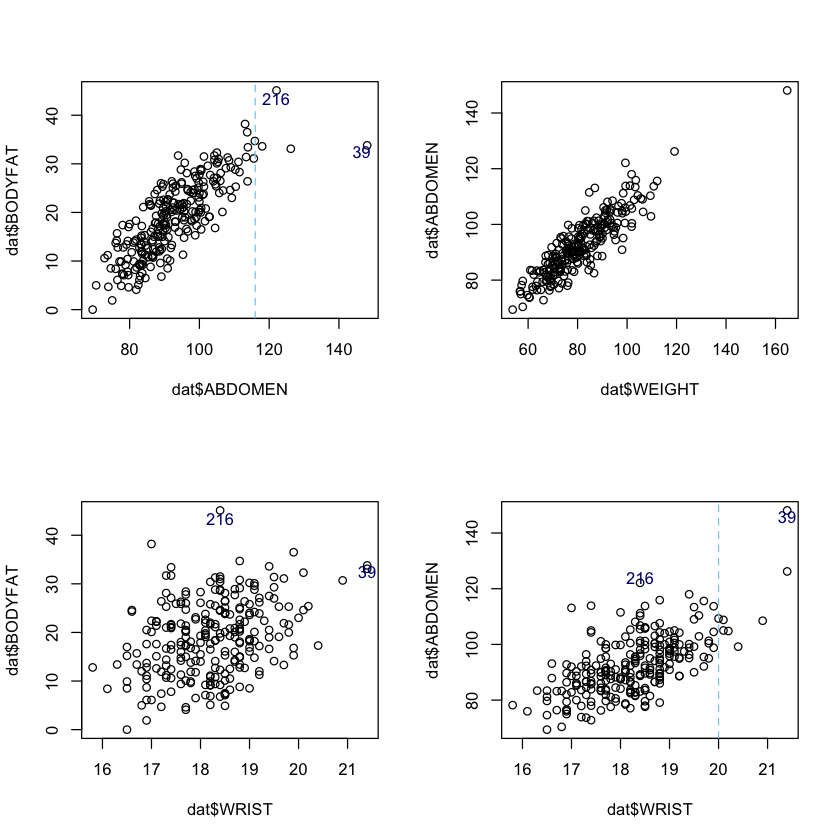

In [13]:
par(mfrow=c(2,2))
plot(dat$BODYFAT~dat$ABDOMEN)
abline(v=116,col="skyblue",lty="dashed")
text(122,43.5,"216",col="navyblue",cex=1)
text(146.5,32.5,"39",col="navyblue",cex=1)
plot(dat$ABDOMEN~dat$WEIGHT)
plot(dat$BODYFAT~dat$WRIST)
text(18.4,43.5,"216",col="navyblue",cex=1)
text(21.4,32.5,"39",col="navyblue",cex=1)
plot(dat$ABDOMEN~dat$WRIST)
abline(v=20,col="skyblue",lty="dashed")
text(18.4,124,"216",col="navyblue",cex=1)
text(21.4,146,"39",col="navyblue",cex=1)

There exists an obvious linear relationship between Abdomen and Weight,so the second model (m2) is unreliable because of the multicollinearity.The vif test and high correlation between the two variables also support this statement.
The fourth model has the same problem of multicollinearity.

In [14]:
cor(dat$ABDOMEN,dat$WEIGHT)
vif(m2)
vif(m4)

[1] 0.8879967

ABDOMEN   WEIGHT 
4.728986 4.728986

ABDOMEN   WEIGHT    WRIST  FOREARM 
4.864505 7.040909 2.272948 1.793454

Althouth there's strong linearity between Abdomen and Bodyfat, Bodyfat is influenced by other factors with higher abdomen level and it seems to be a nonlinear relationship on the right side of the vertical line.
Wrist circumsference has no big influence on lower weight males, but extremely large wrist circumsference will lead to large abdomen circumsference and heavy weight and we can see the Abdomen increases rapidly when Wrist is larger than 20.
To further explore their mutual influences, we turn to use interaction plots.

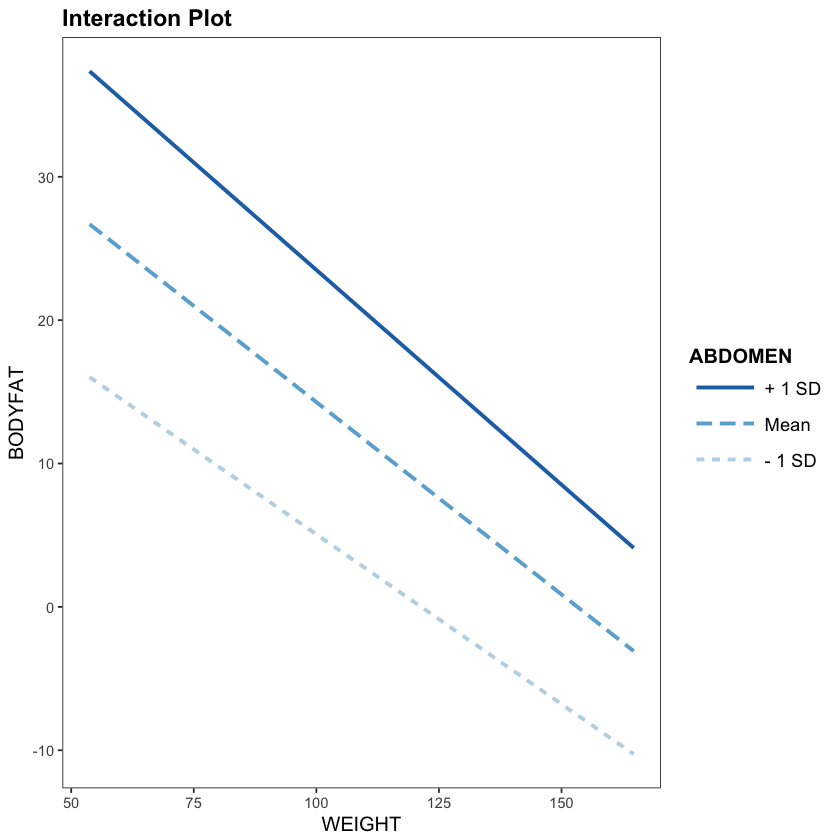

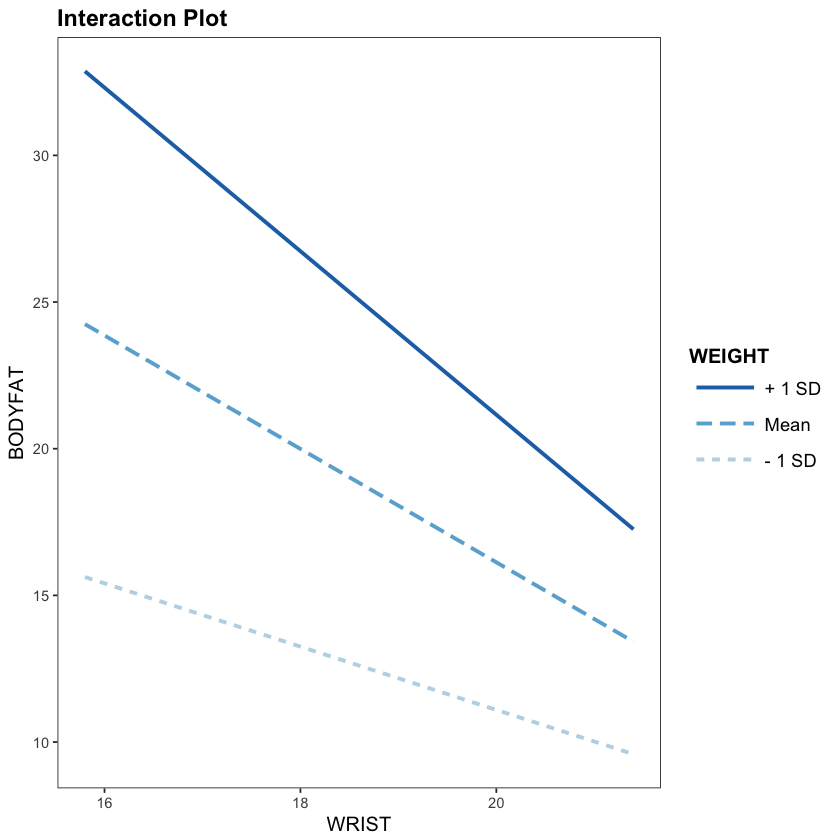

In [15]:
library(jtools)
par(mfrow=c(1,2))
interact_plot(lm(BODYFAT~WEIGHT*ABDOMEN,data=dat), pred = "WEIGHT", modx = "ABDOMEN",main="Interaction Plot")
interact_plot(lm(BODYFAT~WEIGHT*WRIST,data=dat), pred = "WRIST", modx = "WEIGHT",main="Interaction Plot")

Out of our expectation, at same Abdomen level, heavier males will have lower bodyfat. Meanwhile, with same weight level, males with larger wrist circumsference will have lower bodyfat.
Therefore, we decide to include the WEIGHT:WRIST interaction term into our model, to interprete their complicated relationships, and it turns out to be a really good model.

In [16]:
m5<-lm(BODYFAT~ABDOMEN+WEIGHT:WRIST,data=dat)
summary(m5)
vif(m5)
mean(m5$residuals^2)


Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT:WRIST, data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.1691 -2.9940 -0.1346  3.0783  9.0309 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -45.766753   2.561257 -17.869  < 2e-16 ***
ABDOMEN        0.913361   0.046845  19.498  < 2e-16 ***
WEIGHT:WRIST  -0.013302   0.001625  -8.187  1.4e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.009 on 249 degrees of freedom
Multiple R-squared:  0.7323,	Adjusted R-squared:  0.7301 
F-statistic: 340.5 on 2 and 249 DF,  p-value: < 2.2e-16


ABDOMEN WEIGHT:WRIST 
    3.985461     3.985461

[1] 15.87806